In [1]:
import spacy
from spacy.matcher import Matcher
from spacy.matcher import PhraseMatcher
import pandas as pd
import matplotlib.pyplot as plt

import fitz # 老师课上用的
import pdfplumber
from transformers import pipeline  # Hugging Face NLP 模型

## Q1 How is Fluence's expansion process?

### 解析PDF文件并清理乱码

In [2]:
import fitz  # PyMuPDF

def extract_text_from_pdf(pdf_path):
    text = ""
    doc = fitz.open(pdf_path)
    for page in doc:
        text += page.get_text("text") + "\n"
    return text

# 解析3年的10-K报告
pdf_2022 = extract_text_from_pdf("2022.Sep.pdf")
pdf_2023 = extract_text_from_pdf("2023.Sep.pdf")
pdf_2024 = extract_text_from_pdf("2024.Sep.pdf")

In [3]:
def clean_text(text):
    return text.encode("utf-8", "ignore").decode("utf-8")  # 去除无法解析的字符

pdf_2022 = clean_text(pdf_2022)
pdf_2023 = clean_text(pdf_2023)
pdf_2024 = clean_text(pdf_2024)

### 初步观察

In [4]:
# 加载已安装的 SpaCy NLP 模型
nlp = spacy.load("en_core_web_sm")

def extract_key_metrics_sentences(text):
    """
    提取包含 "Key Operating Metrics" 及相关单位 (GW, GWh, MW) 的句子
    """
    doc = nlp(text)  # 使用 spaCy 进行文本分析
    keywords = ["Key Operating Metrics", "GW", "GWh", "MW"]
    relevant_sentences = []
    for sent in doc.sents:
        if any(kw in sent.text for kw in keywords):
            cleaned_sentence = sent.text.replace("\n", " ").strip()  # 去掉句中换行
            relevant_sentences.append(cleaned_sentence)
    
    return relevant_sentences if relevant_sentences else ["No relevant sentence found."]

# 提取 2022, 2023, 2024 10-K 报告中的Key Operating Metrics段落
metrics_2022 = extract_key_metrics_sentences(pdf_2022)
metrics_2023 = extract_key_metrics_sentences(pdf_2023)
metrics_2024 = extract_key_metrics_sentences(pdf_2024)

# 让输出更清晰，高亮关键部分
def print_formatted_metrics(year, metrics):
    print(f"\n\033[1;34m{year} Key Metrics Sentences:\033[0m")  # 蓝色高亮年份
    for sentence in metrics:
        print("●", sentence.replace("GW", "\033[1;32mGW\033[0m")   # 绿色高亮 GW
                           .replace("energy storage assets", "\033[1;33menergy storage assets\033[0m")   # 黄色高亮 energy storage assets
                           .replace("renewable energy assets", "\033[1;31mrenewable energy assets\033[0m")   # 品红高亮 renewable energy assets
                           .replace("global", "\033[1;35mglobal\033[0m"))  # 紫色高亮acquire
        

# 打印格式化后的输出
print_formatted_metrics("2022", metrics_2022)
print_formatted_metrics("2023", metrics_2023)
print_formatted_metrics("2024", metrics_2024)


2022 Key Metrics Sentences:
● 5  As of September 30, 2022, we had 1.8 gigawatts (“GW”) of energy storage assets deployed and 3.7 GW of contracted backlog across 44 markets in 36 countries with a gross global pipeline of 37.7 GW.
● As of September  30, 2022, our global operational and maintenance (“O&M”) services team was providing services for 2.0 GW of energy storage assets, with a further 2.0 GW of contracted backlog.
● Management’s Discussion and Analysis of Financial Condition and Results of Operations—Key Operating Metrics” for additional information regarding our deployed assets, contracted backlog and pipeline.
● As of September 30, 2022, we had an aggregate of 13.7 GW of renewable energy assets using Fluence Mosaic and 3.6 GW of contracted backlog related to renewable and energy storage assets.
● According to BloombergNEF, global annual energy storage capacity installations, excluding the residential market, grew from 0.6 GW a year in 2015 to 16 GW a year in 2022, and are expe

### 使用Hugging Face API提取所需数据

In [5]:
from transformers import pipeline

# **加载 Hugging Face 预训练 BERT 模型**
nlp = pipeline("ner", model="dslim/bert-large-NER")

def extract_gw_huggingface(text):
    """ 用 Hugging Face 进行命名实体识别 (NER) """
    words = text.split()
    extracted_data = []

    for i in range(len(words) - 4):
        if words[i+1].lower() in ["gw", "gwh", "gigawatts"] and words[i+2].lower() == "of":
            num = words[i]  # 提取数值
            category = " ".join(words[i+3:i+6])  # 提取类别
            sentence = " ".join(words[max(0, i-5): i+6])  # 提取完整句子
            extracted_data.append({"Value": num, "Unit": words[i+1], "Category": category, "Sentence": sentence})

    return extracted_data

# **直接用 Hugging Face 提取 GW 数据**
gw_data_2022 = extract_gw_huggingface(pdf_2022)
gw_data_2023 = extract_gw_huggingface(pdf_2023)
gw_data_2024 = extract_gw_huggingface(pdf_2024)

# **存入 Pandas DataFrame 并显示**
df_2022 = pd.DataFrame(gw_data_2022)
df_2023 = pd.DataFrame(gw_data_2023)
df_2024 = pd.DataFrame(gw_data_2024)

pd.set_option('display.max_colwidth', None) 

Some weights of the model checkpoint at dslim/bert-large-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


In [6]:
df_2022

,Value,Unit,Category,Sentence
0,3.7,GW,contracted backlog across,energy storage assets deployed and 3.7 GW of contracted backlog across
1,2.0,GW,"energy storage assets,","team was providing services for 2.0 GW of energy storage assets,"
2,2.0,GW,contracted backlog. See,"storage assets, with a further 2.0 GW of contracted backlog. See"
3,13.7,GW,renewable energy assets,we had an aggregate of 13.7 GW of renewable energy assets
4,3.6,GW,contracted backlog related,assets using Fluence Mosaic and 3.6 GW of contracted backlog related
5,8,GW,assets under management,management platform that currently has 8 GW of assets under management
6,3.1,GW,energy storage by,Virginia has a mandate for 3.1 GW of energy storage by
7,1.8,GW,"energy storage products,","30, 2022 we deployed cumulative 1.8 GW of energy storage products,"


In [7]:
df_2023

,Value,Unit,Category,Sentence
0,4.6,GW,contracted backlog across,energy storage assets deployed and 4.6 GW of contracted backlog across
1,2.8,GW,"energy storage assets,","team was providing services for 2.8 GW of energy storage assets,"
2,2.9,GW,contracted backlog. As,"storage assets, with a further 2.9 GW of contracted backlog. As"
3,15.5,GW,renewable energy assets,we had an aggregate of 15.5 GW of renewable energy assets
4,6.8,GW,contracted backlog related,using Fluence IQ Platform and 6.8 GW of contracted backlog related
5,3.1,GW,energy storage by,Virginia has a mandate for 3.1 GW of energy storage by


In [8]:
df_2024

,Value,Unit,Category,Sentence
0,With,gigawatts,"projects successfully contracted,","full potential of renewable portfolios. With gigawatts of projects successfully contracted,"
1,7.5,GW,contracted backlog across,energy storage assets deployed and 7.5 GW of contracted backlog across
2,4.3,GW,"energy storage assets,","team was providing services for 4.3 GW of energy storage assets,"
3,4.1,GW,contracted backlog. As,"storage assets, with a further 4.1 GW of contracted backlog. As"
4,18.3,GW,renewable energy assets,we had an aggregate of 18.3 GW of renewable energy assets
5,10.6,GW,contracted backlog related,using Fluence digital offerings and 10.6 GW of contracted backlog related
6,2,GWh,"storage assets, a","in Spain targeting more than 2 GWh of storage assets, a"


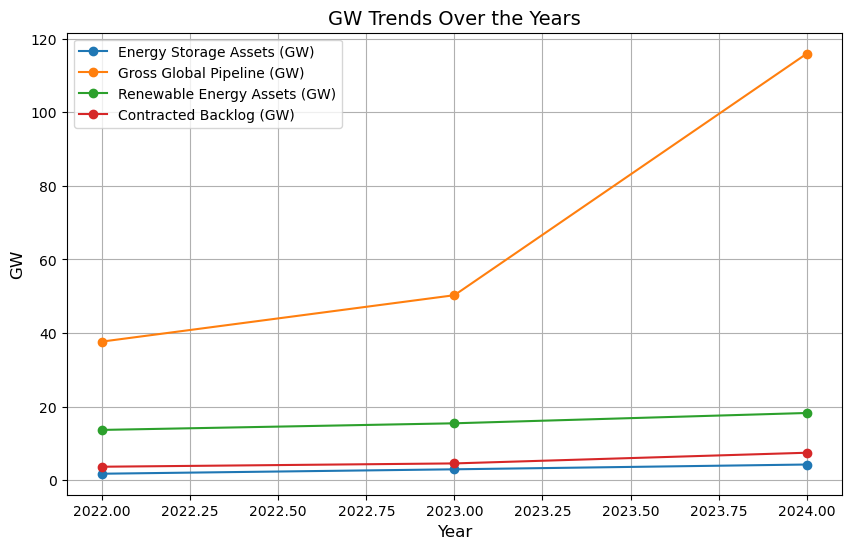

In [9]:
dataQ1 = {
    "Year": [2022, 2023, 2024],
    "Energy Storage Assets (GW)": [1.8, 3.0, 4.3],
    "Gross Global Pipeline (GW)": [37.7, 50.3, 115.9],
    "Renewable Energy Assets (GW)": [13.7, 15.5, 18.3],
    "Contracted Backlog (GW)":[3.7, 4.6, 7.5] 
}

df = pd.DataFrame(dataQ1)
plt.figure(figsize=(10, 6))

for column in df.columns[1:]:
    plt.plot(df["Year"], df[column], marker='o', linestyle='-', label=column)

plt.xlabel("Year", fontsize=12)
plt.ylabel("GW", fontsize=12)
plt.title("GW Trends Over the Years", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()